In [ ]:
import sys
sys.path.append('../..')

In [ ]:
%matplotlib widget

In [8]:
from lcs.configs import *
from lcs.joint_learning import *
import numpy as np 
from lcs import TEXTWIDTH, PAGEHEIGHT
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from lcs.plotting_utils import *
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator
from lcs_mnist.mnist_lcs_plotting_utils import get_first_crossing_times
from functools import partial

In [ ]:
overrides = dict(num_seeds=10, log_aux=False, T_tape=10000)
cfg = Config(**(cfg_full_ | overrides))
cfg_baseline = Config(**(cfg_forgetful_ | overrides))

In [9]:
tape = run_config(cfg)

[INFO] [2024-11-21 09:38:01,072] in lcs.joint_learning: Running 10 seeds on device TFRT_CPU_0 with config Config(input_size=20,
       output_size=10,
       num_seeds=10,
       num_contexts=2,
       num_paths=2,
       batch_size=200,
       initialization_scale=0.01,
       gate_second=True,
       turn_off_regularization=False,
       regularization_strength=0.1,
       num_layers=1,
       hidden_size=10,
       context_model=True,
       name='full',
       regularization_type=[('nonnegative', 1),
                            ('gating_manifold_L1', 10.0),
                            ('L2_W', 0.0)],
       shared_teachers=False,
       shared_concat_teachers=False,
       c_gt_curriculum='A_B__',
       Y_tgt=None,
       W_teachers='generate',
       use_X=True,
       metric='cosine',
       teacher_mode='orthogonal',
       teacher_xx=0.0,
       teacher_scale='d_in',
       teacher_rotate=True,
       t_tot=20.0,
       T_tot=20000,
       num_blocks=21,
       block_duration=

In [10]:
tape_base = run_config(cfg_baseline)

[INFO] [2024-11-21 09:38:13,290] in lcs.joint_learning: Running 10 seeds on device TFRT_CPU_0 with config Config(input_size=20,
       output_size=10,
       num_seeds=10,
       num_contexts=2,
       num_paths=2,
       batch_size=200,
       initialization_scale=0.01,
       gate_second=True,
       turn_off_regularization=False,
       regularization_strength=0.0,
       num_layers=1,
       hidden_size=10,
       context_model=True,
       name='forgetful',
       regularization_type=[('nonnegative', 1),
                            ('gating_manifold_L1', 10.0),
                            ('L2_W', 0.0)],
       shared_teachers=False,
       shared_concat_teachers=False,
       c_gt_curriculum='A_B__',
       Y_tgt=None,
       W_teachers='generate',
       use_X=True,
       metric='cosine',
       teacher_mode='orthogonal',
       teacher_xx=0.0,
       teacher_scale='d_in',
       teacher_rotate=True,
       t_tot=20.0,
       T_tot=20000,
       num_blocks=21,
       block_dura

In [11]:
s = 2
fig = plt.figure(figsize=(s*TEXTWIDTH, s*PAGEHEIGHT*0.2), layout='constrained')

mosaic = """
a.d
b.e
csf
"""

axd = fig.subplot_mosaic(mosaic, width_ratios=[1, .01, 1])

ax_loss = axd['a']
ax_c = axd['b']

ax_sim = axd['c']

ax_delta_W = axd['d']
ax_delta_c = axd['e']

ax_sv_W = axd['s']
ax_sv_W.set_box_aspect(1)
ax_sv_W.set_zorder(1)
ax_sv_W.patch.set_facecolor('white')
ax_sv_W.axis('off')
ax_hyperparams = axd['f']

c_baseline = "tab:grey"
plt.show()

In [12]:
ax = ax_loss
ax.cla()
plot_loss(ax, tape, cfg, skip=1)
plot_loss(ax, tape_base, cfg_baseline, skip=1, color=c_baseline, zorder=-1)
ax.dataLim.y0 = 0
ax.dataLim.y1 = .5
ax.set_yticks([0, .5,])
ax.autoscale_view()

In [13]:
ax = ax_c
ax.cla()
plot_c(ax, tape, cfg,)
ax.dataLim.y0 = 0
ax.dataLim.y1 = 1.5
ax.autoscale_view()

In [14]:
ax = ax_delta_W
ax.cla()
plot_delta_W(ax, tape, cfg, normalized=True)
plot_delta_W(ax, tape_base, cfg_baseline, zorder=-1, color=c_baseline, normalized=True)
ax.set_ylim(-.1, 1.7)
ax.yaxis.set_major_locator(plt.MaxNLocator(2))

In [15]:
ax = ax_sim
ax.cla()
plot_similarity(ax, tape, cfg,)

In [16]:
ax = ax_delta_c
ax.cla()
ax.spines['right'].set_visible(True)
plot_delta_c(ax, tape, cfg, alpha=.8)
ax.yaxis.set_major_locator(plt.MaxNLocator(2))

ax_weights = ax_delta_c.twinx()
ax = ax_weights
plot_norm_w(ax, tape, cfg, ls="--", lw=plt.rcParams['lines.linewidth']*2)
ax.set_ylabel(r"norm $||\boldsymbol{W}||$ (dashed)")

Text(0, 0.5, 'norm $||\\boldsymbol{W}||$ (dashed)')

In [17]:
ax_c.legend(['$c^1$', '$c^2$'], loc='center right')

ax_sim.set_ylabel('student-teacher' + '\n' + 'alignment ' + r'$\langle W^{\star m} W^{p T}\rangle$')

from matplotlib.lines import Line2D

custom_lines = [Line2D([0], [0], ls="-", c="gray"),
                Line2D([0], [0], ls="--",  c="gray"),]

ax_sim.legend(custom_lines, [r'$m = p$', r'$m \neq p$'], loc='center right')


custom_lines = [Line2D([0], [0], ls="-", c="C0"),
                Line2D([0], [0], ls="-",  c="C1"),]

ax_c.legend(custom_lines, ['$c^1$', '$c^2$'], loc='center right')

axes = [ax_c, ax_hyperparams, ax_loss, ax_sim, ax_weights]

In [20]:
get_first_crossing_times_ = partial(get_first_crossing_times, thsd=.1)

ax = ax_hyperparams
ax.cla()
blocks, idcs_first = get_first_crossing_times_(tape.loss, tape.c_gt1, cfg)
t_first = idcs_first * cfg.dt_tape

t_block_centers = np.linspace(0, tape.t.max(), t_first.shape[-1]) + cfg.block_duration / 2
fill_between(ax, x=t_block_centers, y=t_first / cfg.W_tau, c='k', label="flexible",  marker="o", markersize=plt.rcParams['lines.markersize']/2)

blocks, idcs_first = get_first_crossing_times_(tape_base.loss, tape_base.c_gt1, cfg_baseline)
t_first = idcs_first * cfg.dt_tape

fill_between(ax, x=t_block_centers[:-1], y=(t_first / cfg.W_tau)[:, :-1], c=c_baseline, label="forgetful", marker="o", markersize=plt.rcParams['lines.markersize']/2)
ax.set_ylabel(r'time to $\mathcal{L} \approx 0.1$')

ax.yaxis.set_major_locator(MaxNLocator(3))

In [21]:
l_flex = Line2D([0], [0], color='k', marker='none', markersize=plt.rcParams['lines.markersize']/2, label='flexible')
l_forget = Line2D([0], [0], color=c_baseline, marker='none', markersize=plt.rcParams['lines.markersize']/2, label='forgetful')
axd["a"].legend(handles=[l_flex, l_forget], loc='upper right')

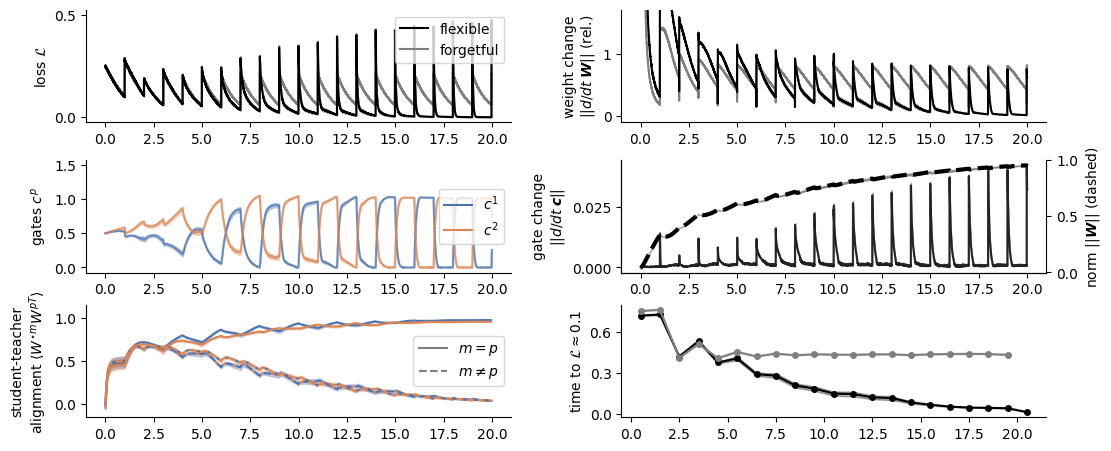

In [22]:
fig

In [23]:
setup_axes_labels(axd, labels=[k.upper() if k not in ['s'] else '' for k in axd.keys() ])

for k, ax in axd.items():
    if ax in [ax_sv_W,]:
        continue 

    ax.set_xlim(0, tape.t.max())

    indicate_contexts(ax, tape, cfg)
    tick_every = 5
    ax.xaxis.set_major_locator(plt.MultipleLocator(tick_every * cfg.block_duration))

    if k.lower() not in ['c', 'f']:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel('time $t$')
       
fig.align_labels()

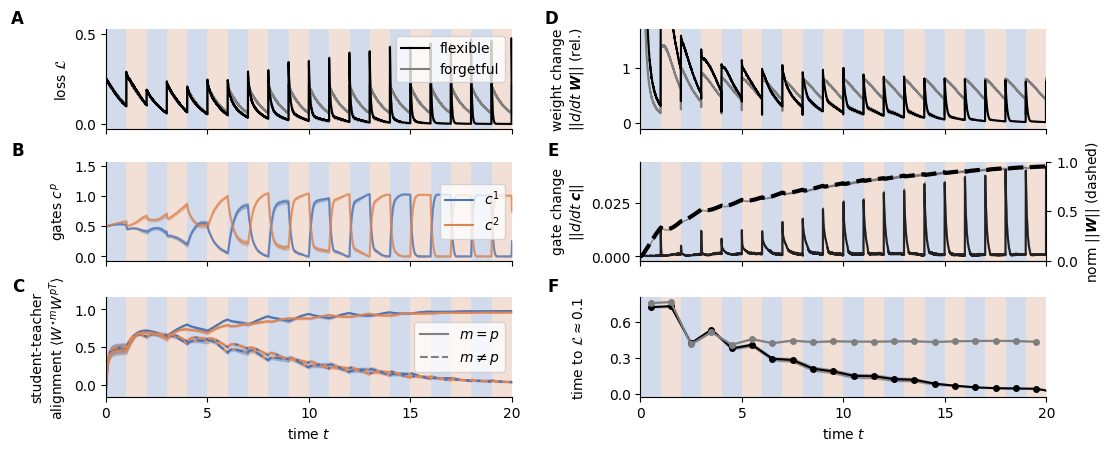

In [24]:
fig